In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, recall_score, accuracy_score, f1_score, confusion_matrix, precision_score
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, PowerTransformer, PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier, XGBRegressor

pd.options.display.max_columns = 999
import warnings
warnings.filterwarnings('ignore')

In [237]:
df = pd.read_csv('Absenteeism.csv', sep = ';')

# Data preprocessing

In [238]:
df.drop(columns = 'ID', inplace = True) #irrelevant

In [239]:
b = []
for i in df['Absenteeism time in hours']:
    if i > 0 :
        b.append(1)
    else:
        b.append(0)

In [240]:
df

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,14,7,3,1,289,36,13,33,264.604,93,0,1,2,1,0,1,90,172,30,8
736,11,7,3,1,235,11,14,37,264.604,93,0,3,1,0,0,1,88,172,29,4
737,0,0,3,1,118,14,13,40,271.219,95,0,1,1,1,0,8,98,170,34,0
738,0,0,4,2,231,35,14,39,271.219,95,0,1,2,1,0,2,100,170,35,0


In [241]:
df['Absent'] = b #classification target

In [242]:
df.drop(columns = ['Reason for absence', 'Absenteeism time in hours'], inplace = True) #it will be obvious if we include the reason for absence and absenteeism time

In [243]:
df.drop(columns = ['Month of absence', 'Day of the week'], inplace = True) #it will be obvious if we include the month of absence and day of week. We use seasons instead (season more inmpactful to person's health)

In [245]:
X = df.drop(columns = 'Absent')
y = df['Absent']
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y , test_size = 0.3, random_state =42)

In [246]:
df['Absent'].value_counts(normalize = True)

1    0.940541
0    0.059459
Name: Absent, dtype: float64

Minority = not absent
majority = absent
1 = absent (not present)
0 = not absent (present)
True positive = Actual absent, prediction absent
True negative = Actual not absent, prediction not absent
False positive =  Actual not absent (present), but the prediction is absent
False negative = Actual absent but the prediction is present -> main concern 

MAIN CONCERN
- our main concern is to supress the number of false negative while also having least number of false positive. (balancing)
- Why we want to balance out the false positive and false negative. 
  Case:
  After detecting the employee that tends to go sick. the company apporach is to examine the employees health to mental-wellness-program and healthy-program. Also taking several health examination. If we have big false positive then company have to pay more for the program and examination (more people that detected tends to go absent but the actual he is healthy). Also we need to supress the false negative so that our prediction is more likely to be accurate in predicting people that tends to go absent.
  
Because the data is imbalance so we focus on tuning the minority class which is 0 (not absent) to get more accurate prediction

In [247]:
df

,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absent
0,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,1
1,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,1
3,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,1
4,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,1,289,36,13,33,264.604,93,0,1,2,1,0,1,90,172,30,1
736,1,235,11,14,37,264.604,93,0,3,1,0,0,1,88,172,29,1
737,1,118,14,13,40,271.219,95,0,1,1,1,0,8,98,170,34,0
738,2,231,35,14,39,271.219,95,0,1,2,1,0,2,100,170,35,0


In [248]:
# Base model
LR = LogisticRegression()
LR.fit(X_train,y_train)

LogisticRegression()

              precision    recall  f1-score   support

           0       0.50      0.15      0.24        13
           1       0.95      0.99      0.97       209

    accuracy                           0.94       222
   macro avg       0.72      0.57      0.60       222
weighted avg       0.92      0.94      0.93       222



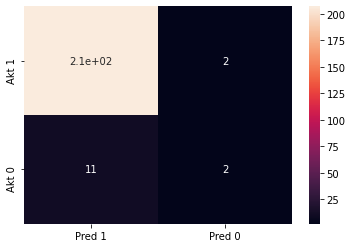

In [249]:
y_LR_test = LR.predict(X_test)
print(classification_report(y_test, y_LR_test))
cm_LR_test = confusion_matrix(y_test, y_LR_test, labels = [1,0])
df_LR_test = pd.DataFrame(data=cm_LR_test, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0'])
sns.heatmap(df_LR_test, annot=True)
plt.show()

In [250]:

KNN = KNeighborsClassifier()
KNN.fit(X_train,y_train)

KNeighborsClassifier()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.94      1.00      0.97       209

    accuracy                           0.94       222
   macro avg       0.47      0.50      0.48       222
weighted avg       0.89      0.94      0.91       222



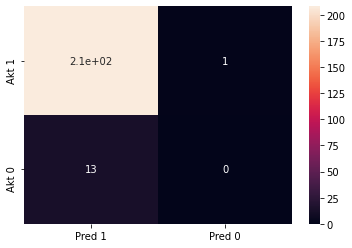

In [251]:
y_KNN_test = KNN.predict(X_test)
print(classification_report(y_test, y_KNN_test))
cm_KNN_test = confusion_matrix(y_test, y_KNN_test, labels = [1,0])
df_KNN_test = pd.DataFrame(data=cm_KNN_test, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0'])
sns.heatmap(df_KNN_test, annot=True)
plt.show()

In [252]:

SVM = SVC()
SVM.fit(X_train,y_train)

SVC()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.94      1.00      0.97       209

    accuracy                           0.94       222
   macro avg       0.47      0.50      0.48       222
weighted avg       0.89      0.94      0.91       222



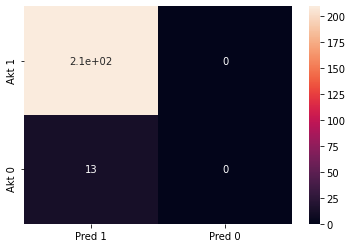

In [253]:
y_SVM_test = SVM.predict(X_test)
print(classification_report(y_test, y_SVM_test))
cm_SVM_test = confusion_matrix(y_test, y_SVM_test, labels = [1,0])
df_SVM_test = pd.DataFrame(data=cm_SVM_test, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0'])
sns.heatmap(df_SVM_test, annot=True)
plt.show()

In [254]:
DT = DecisionTreeClassifier()
DT.fit(X_train,y_train)

DecisionTreeClassifier()

              precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       0.99      1.00      1.00       209

    accuracy                           0.99       222
   macro avg       1.00      0.92      0.96       222
weighted avg       0.99      0.99      0.99       222



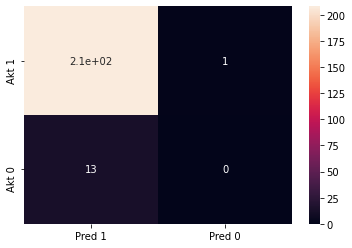

In [255]:
y_DT_test = DT.predict(X_test)
print(classification_report(y_test, y_DT_test))
cm_DT_test = confusion_matrix(y_test, y_DT_test, labels = [1,0])
df_DT_test = pd.DataFrame(data=cm_KNN_test, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0'])
sns.heatmap(df_DT_test, annot=True)
plt.show()

In [256]:
RF = RandomForestClassifier()
RF.fit(X_train,y_train)

RandomForestClassifier()

              precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       0.99      1.00      1.00       209

    accuracy                           0.99       222
   macro avg       1.00      0.92      0.96       222
weighted avg       0.99      0.99      0.99       222



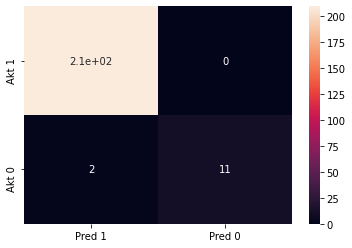

In [257]:
y_RF_test = RF.predict(X_test)
print(classification_report(y_test, y_RF_test))
cm_RF_test = confusion_matrix(y_test, y_RF_test, labels = [1,0])
df_RF_test = pd.DataFrame(data=cm_RF_test, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0'])
sns.heatmap(df_RF_test, annot=True)
plt.show()

# Conclusion on base model
- Random forest has the best recall  in the MINORITY CLASS.
- Decision Tree 2nd best but it has higher false positive
- KNN and SVM recall-precision score is far from accurate
- Logreg still can be improved

In [258]:
# Feature engineering

In [260]:
pipeline_LR = Pipeline([
    ('scale', StandardScaler()),
    ('algo', LogisticRegression())
])
pipeline_KNN = Pipeline([
    ('scale', StandardScaler()),
    ('algo', KNeighborsClassifier())
])
pipeline_SVM = Pipeline([
    ('scale', StandardScaler()),
    ('algo', SVC())
])
pipeline_RF = Pipeline([
    ('scale', StandardScaler()),
    ('algo', RandomForestClassifier())
])


In [261]:
pipeline_LR.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()), ('algo', LogisticRegression())])

              precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       0.99      1.00      1.00       209

    accuracy                           0.99       222
   macro avg       1.00      0.92      0.96       222
weighted avg       0.99      0.99      0.99       222



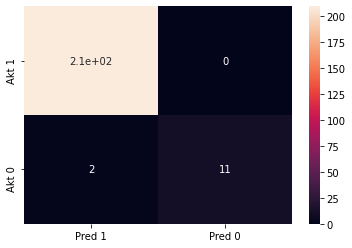

In [262]:
y_LRT_test = pipeline_LR.predict(X_test)
print(classification_report(y_test, y_LRT_test))
cm_LRT_test = confusion_matrix(y_test, y_LRT_test, labels = [1,0])
df_LRT_test = pd.DataFrame(data=cm_LRT_test, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0'])
sns.heatmap(df_LRT_test, annot=True)
plt.show()

In [263]:
pipeline_KNN.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()), ('algo', KNeighborsClassifier())])

              precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       0.99      1.00      1.00       209

    accuracy                           0.99       222
   macro avg       1.00      0.92      0.96       222
weighted avg       0.99      0.99      0.99       222



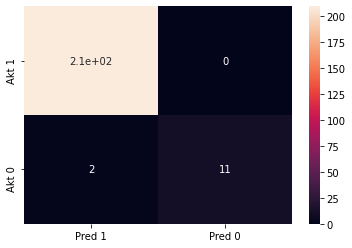

In [264]:
y_KNNT_test = pipeline_KNN.predict(X_test)
print(classification_report(y_test, y_KNNT_test))
cm_KNNT_test = confusion_matrix(y_test, y_KNNT_test, labels = [1,0])
df_KNNT_test = pd.DataFrame(data=cm_KNNT_test, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0'])
sns.heatmap(df_KNNT_test, annot=True)
plt.show()

In [265]:
pipeline_SVM.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()), ('algo', SVC())])

              precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       0.99      1.00      1.00       209

    accuracy                           0.99       222
   macro avg       1.00      0.92      0.96       222
weighted avg       0.99      0.99      0.99       222



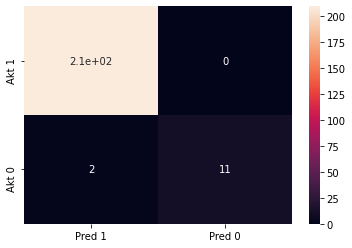

In [266]:
y_SVM_test = pipeline_SVM.predict(X_test)
print(classification_report(y_test, y_SVM_test))
cm_SVM_test = confusion_matrix(y_test, y_SVM_test, labels = [1,0])
df_SVM_test = pd.DataFrame(data=cm_SVM_test, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0'])
sns.heatmap(df_SVM_test, annot=True)
plt.show()

In [267]:
pipeline_RF.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('algo', RandomForestClassifier())])

              precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       0.99      1.00      1.00       209

    accuracy                           0.99       222
   macro avg       1.00      0.92      0.96       222
weighted avg       0.99      0.99      0.99       222



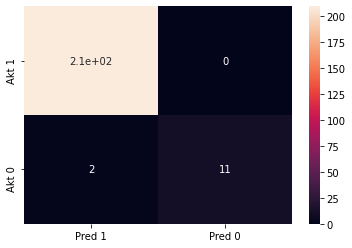

In [268]:
y_RF2_test = pipeline_RF.predict(X_test)
print(classification_report(y_test, y_RF2_test))
cm_RF2_test = confusion_matrix(y_test, y_RF2_test, labels = [1,0])
df_RF2_test = pd.DataFrame(data=cm_RF2_test, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0'])
sns.heatmap(df_RF2_test, annot=True)
plt.show()

# conclusion using scalling
- well all of the algoritm seems to have great score after scalling. recall = 0.85

In [269]:
# Hyperparam

In [270]:
param_KNN = {
    'algo__n_neighbors': np.arange(1,51,2),
    "algo__p" : [1,2],
    'algo__weights' : ['uniform', 'distance']
}

In [271]:
skf = StratifiedKFold(n_splits = 3)

In [272]:
KNN_GS = GridSearchCV(pipeline_KNN, param_KNN, cv = skf, scoring = 'f1', n_jobs= -1, verbose = 1)

In [273]:
KNN_GS.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.9s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('algo', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'algo__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49]),
                         'algo__p': [1, 2],
                         'algo__weights': ['uniform', 'distance']},
             scoring='f1', verbose=1)

In [274]:
KNN_GS.best_params_

{'algo__n_neighbors': 1, 'algo__p': 2, 'algo__weights': 'uniform'}

              precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       0.99      1.00      1.00       209

    accuracy                           0.99       222
   macro avg       1.00      0.92      0.96       222
weighted avg       0.99      0.99      0.99       222



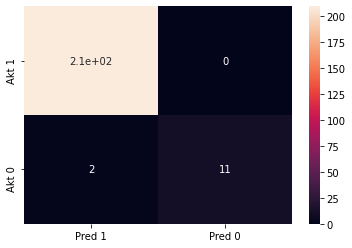

In [275]:
KNN_Tuned = KNN_GS.best_estimator_
y_KNN2_test = KNN_Tuned.predict(X_test)
print(classification_report(y_test, y_KNN2_test))
cm_KNN2_test = confusion_matrix(y_test, y_KNN2_test, labels = [1,0])
df_KNN2_test = pd.DataFrame(data=cm_KNN2_test, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0'])
sns.heatmap(df_SVM_test, annot=True)
plt.show()


In [334]:
param_SVM = {
    'algo__C' : np.logspace(-3,3,7),
    'algo__gamma' : np.arange(10, 101, 10),
    'algo__class_weight': [{0 : 1- x, 1 : x} for x in [.1, .2, .3, .4, .5]]
}

In [335]:
SVM_GS = GridSearchCV(pipeline_SVM, param_SVM, cv = skf, scoring = 'recall', n_jobs= -1, verbose = 1)

In [336]:
SVM_GS.fit(X_train,y_train)

Fitting 3 folds for each of 350 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    3.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('algo', SVC())]),
             n_jobs=-1,
             param_grid={'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'algo__class_weight': [{0: 0.9, 1: 0.1},
                                                {0: 0.8, 1: 0.2},
                                                {0: 0.7, 1: 0.3},
                                                {0: 0.6, 1: 0.4},
                                                {0: 0.5, 1: 0.5}],
                         'algo__gamma': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])},
             scoring='recall', verbose=1)

In [337]:
SVM_GS.best_params_

{'algo__C': 0.001, 'algo__class_weight': {0: 0.9, 1: 0.1}, 'algo__gamma': 10}

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.94      1.00      0.97       209

    accuracy                           0.94       222
   macro avg       0.47      0.50      0.48       222
weighted avg       0.89      0.94      0.91       222



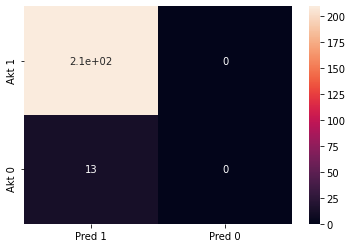

In [338]:
SVM_Tuned = SVM_GS.best_estimator_
y_SVMT_test = SVM_Tuned.predict(X_test)
print(classification_report(y_test, y_SVMT_test))
cm_SVMT_test = confusion_matrix(y_test, y_SVMT_test, labels = [1,0])
df_SVMT_test = pd.DataFrame(data=cm_SVMT_test, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0'])
sns.heatmap(df_SVMT_test, annot=True)
plt.show()


In [319]:
param_RF = {
    "n_estimators" : np.arange(100, 501, 100), 
    "max_depth" : [None, 5, 10, 15], 
    "min_samples_leaf" : np.arange(1, 17, 5), 
    "max_features" : [0.3, 0.5, 0.7, 0.8],
    "class_weight" : [{0 : 1- x, 1 : x} for x in [.1, .2, .3, .4, .5]]
}

In [320]:
RF_T = GridSearchCV(RandomForestClassifier(), param_RF, cv=skf, n_jobs=-1, verbose=1, scoring='recall')

In [321]:
RF_T.fit(X_train, y_train)

Fitting 3 folds for each of 1600 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:  6.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.9, 1: 0.1}, {0: 0.8, 1: 0.2},
                                          {0: 0.7, 1: 0.3}, {0: 0.6, 1: 0.4},
                                          {0: 0.5, 1: 0.5}],
                         'max_depth': [None, 5, 10, 15],
                         'max_features': [0.3, 0.5, 0.7, 0.8],
                         'min_samples_leaf': array([ 1,  6, 11, 16]),
                         'n_estimators': array([100, 200, 300, 400, 500])},
             scoring='recall', verbose=1)

In [322]:
RF_T.best_params_

{'class_weight': {0: 0.9, 1: 0.1},
 'max_depth': None,
 'max_features': 0.3,
 'min_samples_leaf': 1,
 'n_estimators': 100}

              precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       0.99      1.00      1.00       209

    accuracy                           0.99       222
   macro avg       1.00      0.92      0.96       222
weighted avg       0.99      0.99      0.99       222



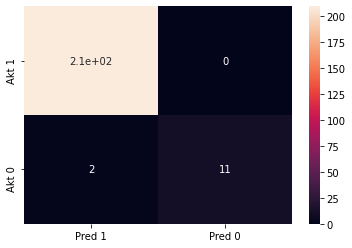

In [323]:
RF_Tuned = RF_T.best_estimator_
y_RF3_test = RF_Tuned.predict(X_test)
print(classification_report(y_test, y_RF3_test))
cm_RF3_test = confusion_matrix(y_test, y_RF3_test, labels = [1,0])
df_RF3_test = pd.DataFrame(data=cm_RF3_test, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0'])
sns.heatmap(df_RF3_test, annot=True)
plt.show()


It seems like the recall score still 0.85 (our best recall score), so we use another metrics called ROC AUC. AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s. By analogy, the Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease.

In [311]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [282]:
y_proba = pipeline_LR.predict_proba(X_test)

In [284]:
pred_1 = y_proba[:, 1]

In [285]:
roc_curve(y_test, pred_1)

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.07692308, 0.07692308, 0.07692308,
        0.07692308, 0.07692308, 0.07692308, 0.07692308, 0.07692308,
        0.07692308, 0.07692308, 0.07692308, 0.07692308, 0.07692308,
        0.07692308, 0.07692308, 0.07692308, 0.15384615, 0.15384615,
        0.15384615, 0.15384615, 0.15384615, 0.15384615, 0.15384615,
        0.15384615, 0.15384615, 0.15384615, 0.15384615, 0.15384615,
        0.15384615, 0.15384615, 0.15384615, 0.15384615, 0.15384615,
        0.15384615, 0.15384615, 0.15384615, 0.15384615, 0.15384615,
        0.15384615, 0.15384615, 0.15384615, 0.15384615, 0.15384615,
        0.15384615, 0.15384615, 1.        ]),
 array([0.        , 0.00478469, 0.03349282, 0.03827751, 0.04784689,
        0.09090909, 0.10047847, 0.1291866 , 0.13875598, 0.15311005,
        0.16746411, 0.20095694, 0.20095694, 0.24880383, 0.25837321,
  

In [286]:
fpr, tpr, threshold = roc_curve(y_test, pred_1)

In [287]:
# AUC Score = Area Under Curve
auc_score = round((auc(fpr, tpr)), 2)

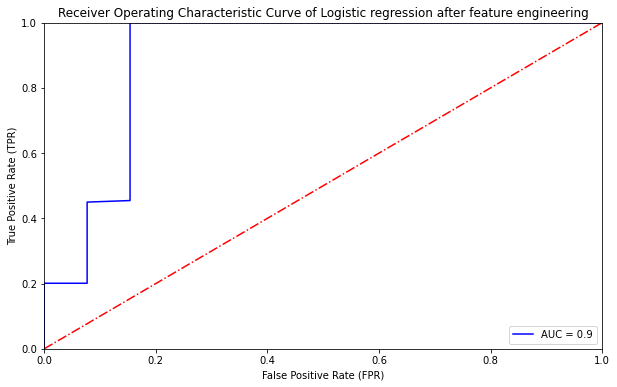

In [288]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, 'b', label = f"AUC = {auc_score}")
plt.plot([0, 1], [0, 1], 'r-.')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic Curve of Logistic regression after feature engineering')
plt.legend()
plt.show()

In [289]:
y_proba = KNN_Tuned.predict_proba(X_test)

In [291]:
pred_1 = y_proba[:, 1]

In [292]:
roc_curve(y_test, pred_1)

(array([0.        , 0.15384615, 1.        ]),
 array([0., 1., 1.]),
 array([2., 1., 0.]))

In [293]:
fpr, tpr, threshold = roc_curve(y_test, pred_1)

In [294]:
# AUC Score = Area Under Curve
auc_score = round((auc(fpr, tpr)), 2)

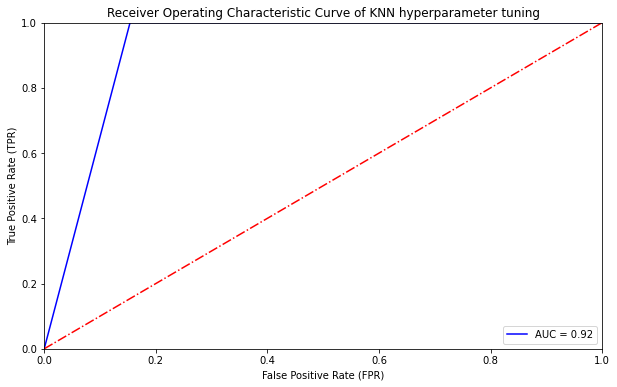

In [295]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, 'b', label = f"AUC = {auc_score}")
plt.plot([0, 1], [0, 1], 'r-.')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic Curve of KNN hyperparameter tuning')
plt.legend()
plt.show()

In [296]:
y_proba = DT.predict_proba(X_test)

In [298]:
pred_1 = y_proba[:, 1]

In [299]:
roc_curve(y_test, pred_1)

(array([0.        , 0.15384615, 1.        ]),
 array([0., 1., 1.]),
 array([2., 1., 0.]))

In [300]:
fpr, tpr, threshold = roc_curve(y_test, pred_1)

In [301]:
# AUC Score = Area Under Curve
auc_score = round((auc(fpr, tpr)), 2)

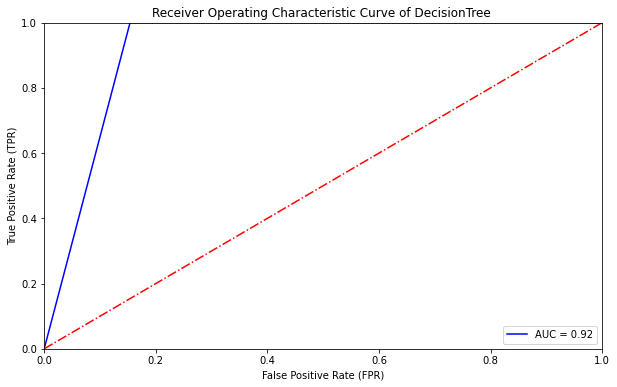

In [302]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, 'b', label = f"AUC = {auc_score}")
plt.plot([0, 1], [0, 1], 'r-.')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic Curve of DecisionTree ')
plt.legend()
plt.show()

In [324]:
y_proba = RF_Tuned.predict_proba(X_test)

In [325]:
pred_1 = y_proba[:, 1]

In [326]:
roc_curve(y_test, pred_1)

(array([0.        , 0.07692308, 0.07692308, 0.07692308, 0.07692308,
        0.07692308, 0.07692308, 0.15384615, 0.15384615, 0.15384615,
        0.46153846, 0.61538462, 1.        ]),
 array([0.        , 0.73684211, 0.82296651, 0.89473684, 0.93301435,
        0.9569378 , 0.96172249, 0.97129187, 0.98564593, 1.        ,
        1.        , 1.        , 1.        ]),
 array([2.  , 1.  , 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.88, 0.24,
        0.16, 0.07]))

In [307]:
fpr, tpr, threshold = roc_curve(y_test, pred_1)

In [327]:
# AUC Score = Area Under Curve
auc_score = round((auc(fpr, tpr)), 2)

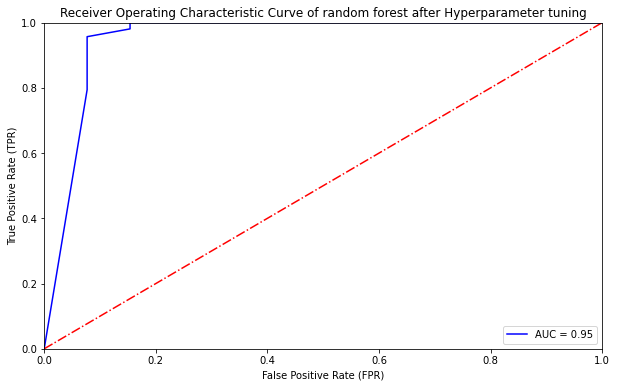

In [329]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, 'b', label = f"AUC = {auc_score}")
plt.plot([0, 1], [0, 1], 'r-.')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic Curve of random forest after Hyperparameter tuning')
plt.legend()
plt.show()

# Conclusion
- the best algoritm for this classification problem is using randomforest algoritm with area under the curve (AUC = 0.95) and recall score 0.85
- the recall score random forest before tuned and after tuned is the same also the AUC score
- tuning does not improve the model recall score

# Save model

In [344]:
import joblib

In [345]:
joblib.dump(RF_Tuned, 'Model RF Absen.jbl')

['Model RF Absen.jbl']